# To Do list: 
- [DO] Run test on new version of PMW
    - Scenario 1: Alice and Bob use disjoint parts of the data set. Any update one makes uniformly reweights the others which may make it less accurate
    - Scenario 2: Alice and Bob have conflicting classes of queries that are incompatible. Alice asks singleton queries Bob asks range queries
- [DO] Try to create an even more adversarial setting where Alice tries to take all the updates (i.e., give Alice more queries than Bob)

In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt

In [2]:
def pmw2(workload, x, T, eps=0.01, k=0, show_messages=True, to_return='pd', analyst_labels = [],
       show_plot=False, show_failure_step=True):
    """
    Implement Private Multiplicative Weights Mechanism (PMW) on a workload of
    linear queries. New arguments to allow for optimizing the amount of
    privacy budget used in each step.
    
    to_return argument determines what the function will return. 
        - if 'pd', pmw() returns pandas df with test data for each 
        query (query, d_t_hat, updated, algo_ans, real_ans, abs_error, 
        rel_error). 
        - if 'update_count', pmw() returns the update count for the total
        amount of queries

    - W = workload of queries (M x k numpy array)
    - x = true database (M x 1 numpy array)
    - eps = privacy budget
    - k = number of update steps
    - T  = update threshold
    """ 
    
    # initialize constants
    m = x.size  # database len
    n = x.sum()
    eta = (math.log(m, np.e) ** (1 / 4)) / (math.sqrt(n))
    # Set k to be the desired number of update rounds
    if k==0: # essentially, if k hasn't been changed from its default value, use the length of the workload
        k = len(workload)  # num of queries
    delta = 1 / (n * math.log(n, np.e))
    x_norm = x / np.sum(x)
    # synthetic databases at time 0 (prior to any queries)
    y_t = np.ones(m) / m
    x_t = np.ones(m) / m

    # append to list of databases y_t and x_t
    x_list = [x_t]
    
    update_list = []
    update_count = 0
    pmw_answers = []
    update_times = []
    d_t_hat_list = []
    
    failure_mode = False # if reaches failure, failure mode because true and only runs lazy rounds
    
    def lazy_round():
        update_list.append('no')
        pmw_answers.append(np.dot(query, x_list[time]))
        x_list.append(x_list[time].round(3))
    
    #inititate first instance of SVT with half the budget and k updates
    #will be reset in the main loop
    SVTtrigger = False 
    SVTepsilon1 =((eps/2)/2)
    SVTepsilon2 = ((eps/2)/2)
    rho = np.random.laplace(loc=0, scale=(1/SVTepsilon1), size=1)[0]
    # iterate through time 
    for time, query in enumerate(workload):
        # Do one round of sparce vector technique 
        
        # compute noisy answer by adding Laplacian noise
        a_t = np.random.laplace(loc=0, scale=(2*k/SVTepsilon2), size=1)[0]
        a_t_hat = (np.dot(query, x_norm)*n ) + a_t

        # difference between noisy and maintained histogram answer
        d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
        
        # lazy round: use maintained histogram to answer the query
        if (abs(d_t_hat) <= T + rho) or failure_mode:
            d_t_hat_list.append(d_t_hat)
            lazy_round()
            continue

        # update round: update histogram and return noisy answer
        else:
            update_times.append(time)
            #make a new noisy query answer using some of the leftover budget
            a_t = np.random.laplace(loc=0, scale=(2*k/eps), size=1)[0]
            a_t_hat = (np.dot(query, x_norm)*n ) + a_t
            d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
            d_t_hat_list.append(d_t_hat)
            
            # step a
            if d_t_hat < 0:
                r_t = query
            else:
                r_t = np.ones(m) - query
            for i, v in enumerate(y_t):
                #y_t[i] = x_list[time][i] * math.exp(-eta * r_t[i])
                y_t[i] = x_list[time][i] * math.exp((d_t_hat/(2*n)) * query[i])
            
            #print(d_t_hat)
            #print(query)
            #print(x_list[time])
            # step b
            x_t = y_t / np.sum(y_t)
            update_count = update_list.count('yes')
            
            if update_count >= k: # threshold for num updates is reached, enter failure_mode
                failure_mode = True
                if show_failure_step:
                    print(f'Failure mode reached at query number {time}: {query}')
                lazy_round()
            else: # threshold for num updates is not reached yet
                x_list.append(x_t.round(3))
                update_list.append('yes') # increment number of updates counter
                pmw_answers.append(a_t_hat / np.sum(x))
                
    update_count = update_list.count('yes')      

    # calculate error
    real_ans = np.matmul(workload, x_norm)
    abs_error = np.abs(pmw_answers - real_ans)
    rel_error = np.abs(abs_error / np.where(real_ans == 0, 0.000001,
                                                real_ans))
    
    def print_outputs():
        np.set_printoptions(suppress=True)
        """Print inputes/outputs to analyze each query"""
        print(f'Original database: {x}\n')
        print(f'Normalized database: {x_norm}\n')
        print(f'Updated Database = {x_t}\n')
        print(f'Update Count = {update_count}\n')
        print(f'{T=}\n')
        print(f'Error Scale Query Answer= {2*((2*k/eps)**2)}\n')
        print(f'Error Scale SVT= {2*((2*k/SVTepsilon2)**2)}\n')
        print(f'Update Parameter Scale = {eta}\n')
        print(f'{delta=}\n')
    
    if show_messages:
        print_outputs()
        
    if show_plot: 
        plt.xticks(range(0, len(workload), 5))
        plt.title('Error across queries:')
        #rel_line, = plt.plot(rel_error, label='Relative Error')
        abs_line, = plt.plot(abs_error, label='Absolute Error')
        for xc in update_times:
            plt.axvline(x=xc, color='red', label='Update Times', linestyle='dashed')
        plt.legend(handles=[abs_line]) #,rel_line])
        
    if to_return == "update_count":
        return update_count

    if to_return == "pd":
        x_list.pop(0).tolist() # remove the first synthetic database to keep length of lists consistent-x_list[t] represents the synthetic database at the end of time t
        
        
        d = {
            'algo_ans': pmw_answers,
            'real_ans': real_ans.tolist(),
            'queries': workload.tolist(), 
            'updated': update_list,
            'abs_error': abs_error,               
#            'rel_error': rel_error,
            'synthetic database': x_list,
            'analyst': analyst_labels,
            'd_t_hat': d_t_hat_list, 

             }
        test_data = pd.DataFrame(data=d)
        test_data = test_data.round(3)
        return test_data

### Initializing workloads and databases

In [7]:
x_small = np.array([20, 160, 20, 20, 20, 180, 20, 20])
normalized = x_small / x_small.sum()
m = x_small.size  # database len
n = x_small.sum()
#print(f'the threshold for failure is {n * math.log(m, np.e) ** (1 / 2)}')

random_array = np.random.randint(2, size=(500,4))
zero_array = np.zeros((500,4))
alice = np.hstack((random_array, zero_array))
bob = np.hstack((zero_array, random_array))

We've shown that Alice can use up all the privacy budget. 

Next, let's take some of the basic adaptations of pmw and see if we can get the same effects to happen or a similar effect were people get similar results indpenedently

### To Dos: 

Instead of having a communal pool of update steps we can do, split the amount of update steps evenly across all analysts. If your update steps are not a multiple of the analysts, you can change the number of update steps.  

Look for the same kind of violation where either Bob or Alice will have more overall error in the joint case as opposed to the independent case.

In the independent state, you can use the existing pmw algorihtm.

Suggestion: When you split it to their individual settings, give them the same amount of update steps that they would've gotten in the group. 

Individually - 1 ep, 5 k. together - 2 ep, 10k. 

### Experiments: 
Try original pmw, adapted w equal update steps pmw, individual: 
1. [done] A and B query disjoint sections
2. A queries the entire dataset except for last index. B queries entire dataset, last index inclusive. 
3. A asks singleton, B asks all range queries
4. [if time] Is total error the right metric? Context: You might run into a case where you get flat error across all of your queries. You may get a lot worse error on one specific query, but the overall error is better. Now Alice and Bob care about the same data. Alice eats all the budget (entire database except for last). Bob cares about entire database, but his queries about the last index has higher error. 
    
    
Scenarios to look for: 
1. Regular pmw performs poorly, but adapted pmw works well. (probably in disjoint setting)
2. Scenarios where regular AND adapted pmw perform poorly

## Scenario 1: Disjoint
#### Alice and Bob


Failure mode reached at query number 12: [1. 1. 1. 0. 0. 0. 0. 0.]
Failure mode reached at query number 12: [1. 1. 1. 0. 0. 0. 0. 0.]
Failure mode reached at query number 15: [0. 0. 0. 0. 1. 0. 0. 1.]


abs_error         
        individual combined
analyst                    
Alice        1.938    1.460
Bob          3.696    1.499

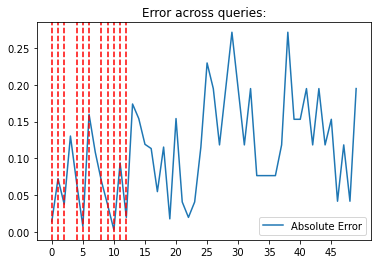

In [88]:
# initialize

random_array = np.random.randint(2, size=(25,4))
zero_array = np.zeros((25,4))
alice = np.hstack((random_array, zero_array))
bob = np.hstack((zero_array, random_array))

# both bob and alice
s1combined_query_data = pmw2(workload=np.vstack((alice, bob)), x=x_small, eps=1, T=40, k=10, to_return='pd', 
              analyst_labels=['Alice'] * 25 + ['Bob'] * 25, show_plot=True, show_messages=False)
combined_error = s1combined_query_data.groupby('analyst').sum()[['abs_error']]

# just alice

s1a_query_data = pmw2(workload=alice, x=x_small, eps=1, T=40, k=10, to_return='pd', 
              analyst_labels=['Alice'] * 25, show_messages=False)
alice_error = s1a_query_data.groupby('analyst').sum()[['abs_error']]

# just bob

s1b_query_data = pmw2(workload=bob, x=x_small, eps=1, T=40, k=10, to_return='pd', 
              analyst_labels=['Bob'] * 25, show_messages=False)
bob_error = s1b_query_data.groupby('analyst').sum()[['abs_error']]

individual_error = pd.concat((alice_error, bob_error))

combined_error.compare(individual_error).rename(columns={"self": "individual", "other": "combined"})

# Results:
- Alice's total error individually:
- Bob's total error individually: 
- Alice's total error in collective: 
- Bob's total error in collective: 

# Conclusion: 

# Follow-ups: